# Remaining Useful Life Prediction
Documentation: https://developer.ibm.com/tutorials/awb-foundation-model-time-series-forecasting/

In [198]:
!git clone "https://github.com/ibm-granite/granite-tsfm.git"
#%cd granite-tsfm
#!pip install ".[notebooks]"
#%cd ../


fatal: destination path 'granite-tsfm' already exists and is not an empty directory.


In [199]:
# Core libraries
import os
import math
import tempfile
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# TSFM libraries
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback
from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)

# TSFM Toolkit libraries
from tsfm_public.toolkit.util import select_by_index
from tsfm_public.toolkit.time_series_forecasting_pipeline import TimeSeriesForecastingPipeline
from tsfm_public.toolkit.visualization import plot_ts_forecasting

# Weights and Biases (WANB) API Key:
# 55786691f5bf98d3d3c2974925c51b1e1622d1d3

In [200]:
# Load datasets
with open('cleaned_data_no_batches/test_data.pkl', 'rb') as file:
    test_df = pickle.load(file)

with open('cleaned_data_no_batches/train_data.pkl', 'rb') as file:
    train_df = pickle.load(file)

# Ensure data are dataframes
if not isinstance(test_df, pd.DataFrame):
    raise ValueError("Loaded data is not a pandas DataFrame.")

if not isinstance(train_df, pd.DataFrame):
    raise ValueError("Loaded data is not a pandas DataFrame.")

In [201]:
print(train_df)

       unit_number  time_cycles  RUL  Bleed Enthalpy  Bypass Ratio  \
0                1            1  191      392.224572      8.417222   
1                1            2  190      392.230768      8.417310   
2                1            3  189      392.236073      8.417390   
3                1            4  188      392.240902      8.417468   
4                1            5  187      392.245241      8.417551   
...            ...          ...  ...             ...           ...   
20626          100          196    4      394.690106      8.478995   
20627          100          197    3      394.692692      8.479073   
20628          100          198    2      394.695409      8.479139   
20629          100          199    1      394.697911      8.479182   
20630          100          200    0      394.699796      8.479210   

       Coolant Bleed, HPT  Coolant Bleed, LPT  Corr. Speed, Fan  Speed, core  \
0               38.937396           23.363193       2388.056196  9056.295210   

In [202]:
# Create additional timesteps for modeling

# Function to expand & interpolate existing points to create new, granular points
def expand_and_interpolate(df, start_date='2023-01-01'):
    # Create an empty DataFrame to store results
    expanded_df = pd.DataFrame()

    # Process each unit number separately
    for unit in df['unit_number'].unique():
        # Filter for the current unit number
        unit_df = df[df['unit_number'] == unit].copy()

        # Expand the time_cycles by creating a range with 4 times the number of cycles
        new_index = np.arange(unit_df['time_cycles'].min(), unit_df['time_cycles'].max() + 1, 0.25)
        unit_df = unit_df.set_index('time_cycles').reindex(new_index)

        # Interpolate all columns linearly
        unit_df = unit_df.interpolate(method='linear')

        # Reset the index and assign the unit number back
        unit_df['unit_number'] = unit
        unit_df = unit_df.reset_index().rename(columns={'index': 'time_cycles'})

        # Add a sequential 'hour' column starting from 0 for each unit
        unit_df['hour'] = range(len(unit_df))

        # Convert 'hour' to a timestamp by adding hours to the start_date
        start_datetime = pd.Timestamp(start_date)
        unit_df['timestamp'] = start_datetime + pd.to_timedelta(unit_df['hour'], unit='h')

        # Append to the result DataFrame
        expanded_df = pd.concat([expanded_df, unit_df], ignore_index=True)

    return expanded_df

# Ensure 'time_cycles' column exists in train_df
if 'time_cycles' not in train_df.columns:
    train_df['time_cycles'] = np.arange(len(train_df))

# Use function
train_df = expand_and_interpolate(train_df)
train_df.tail(5)


,time_cycles,unit_number,RUL,Bleed Enthalpy,Bypass Ratio,"Coolant Bleed, HPT","Coolant Bleed, LPT","Corr. Speed, Fan","Speed, core","Speed, fan","Stat Press, HPC out","Temp, HPC out","Temp, LPC out","Temp, LPT out","Tot Press, HPC out","Tot Press, bypass",phi Fuel Flow Ratio,hour,timestamp
82519,199.75,100,0.25,394.699325,8.479203,38.640426,23.184211,2388.146260,9080.998933,2388.145558,47.817243,1596.041191,643.135686,1418.296556,552.508056,21.609986,520.680014,795,2023-02-03 03:00:00
82520,200.00,100,0.00,394.699796,8.479210,38.640341,23.184220,2388.146369,9081.046712,2388.145675,47.817240,1596.040758,643.135586,1418.298343,552.507783,21.609986,520.679993,796,2023-02-03 04:00:00
82521,200.25,100,0.00,394.699796,8.479210,38.640341,23.184220,2388.146369,9081.046712,2388.145675,47.817240,1596.040758,643.135586,1418.298343,552.507783,21.609986,520.679993,797,2023-02-03 05:00:00
82522,200.50,100,0.00,394.699796,8.479210,38.640341,23.184220,2388.146369,9081.046712,2388.145675,47.817240,1596.040758,643.135586,1418.298343,552.507783,21.609986,520.679993,798,2023-02-03 06:00:00
82523,200.75,100,0.00,394.699796,8.479210,38.640341,23.184220,2388.146369,9081.046712,2388.145675,47.817240,1596.040758,643.135586,1418.298343,552.507783,21.609986,520.679993,799,2023-02-03 07:00:00


In [203]:
# Refine dataset
train_df = train_df.dropna()
train_df = train_df.drop(columns=['time_cycles'])
train_df.columns

Index(['unit_number', 'RUL', 'Bleed Enthalpy', 'Bypass Ratio',
       'Coolant Bleed, HPT', 'Coolant Bleed, LPT', 'Corr. Speed, Fan',
       'Speed, core', 'Speed, fan', 'Stat Press, HPC out', 'Temp, HPC out',
       'Temp, LPC out', 'Temp, LPT out', 'Tot Press, HPC out',
       'Tot Press, bypass', 'phi Fuel Flow Ratio', 'hour', 'timestamp'],
      dtype='object')

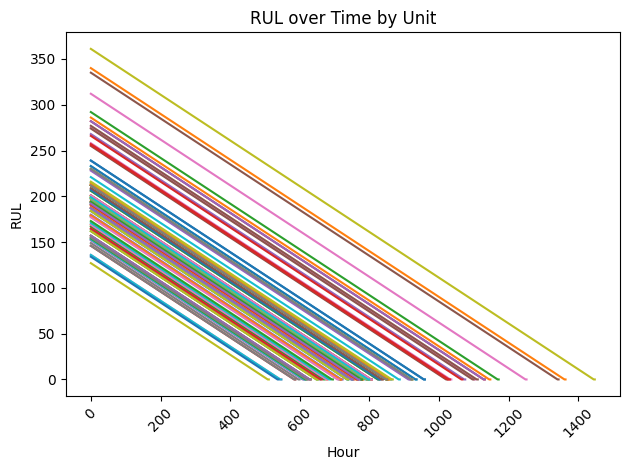

In [204]:
# Plot RUL over time for each unit in the dataset

# Loop through each unique unit number and plot separately
for unit in train_df['unit_number'].unique():
    unit_data = train_df[train_df['unit_number'] == unit]
    plt.plot(unit_data['hour'], unit_data['RUL'], label=f'Unit {unit}')

# Add labels and title
plt.xlabel('Hour')
plt.ylabel('RUL')
plt.title('RUL over Time by Unit')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Forecasting

In [205]:
# Generate train/validation/test split configurations for each unit number in the dataset.
def generate_split_configs(input_df, context_length, unit_numbers=None):

    # If no unit numbers provided, get all unique unit numbers from the data
    if unit_numbers is None:
        unit_numbers = train_df['unit_number'].unique()

    split_configs = {}

    for unit in unit_numbers:
        # Filter data for current unit
        unit_data = input_df[input_df['unit_number'] == unit]
        #unit_data = unit_data.reset_index(drop=True)
        data_length = len(unit_data)

        # Calculate indices for train split (0 to 80%)
        train_start_index = 0
        train_end_index = round(data_length * 0.8)

        # Calculate indices for validation split (80% to 90%)
        # Shift back by context length to ensure first evaluation timestamp follows training data
        eval_start_index = round(data_length * 0.8) - context_length
        eval_end_index = round(data_length * 0.9)

        # Calculate indices for test split (90% to end)
        test_start_index = round(data_length * 0.9) - context_length
        test_end_index = data_length - 1

        # Create split configuration for current unit
        split_configs[unit] = {
            "train": [train_start_index, train_end_index],
            "valid": [eval_start_index, eval_end_index],
            "test": [test_start_index, test_end_index]
        }

    return list(split_configs.values())

In [206]:
# Function to determine actual vs predicted values
def compare_forecast(forecast, date_col, prediction_col, actual_col, hours_out):
  comparisons = pd.DataFrame()
  comparisons[date_col] = forecast[date_col]
  actual = []
  pred = []

  for i in range(len(forecast)):
    pred.append(forecast[prediction_col].values[i][hours_out - 1]) # prediction for next day
    actual.append(forecast[actual_col].values[i][hours_out - 1])

  comparisons['actual'] = actual
  comparisons['pred'] = pred

  return comparisons

In [207]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Results directory
OUT_DIR = "ttm_finetuned_models/"

# Set column parameters
timestamp_column = "timestamp"
target_columns = ["RUL"]
observable_columns = train_df.columns[3:]
observable_columns = observable_columns[:-2]

'''
  ['Bleed Enthalpy','Bypass Ratio',
       'Coolant Bleed, HPT', 'Coolant Bleed, LPT', 'Corr. Speed, Fan',
       'Speed, core', 'Speed, fan', 'Stat Press, HPC out', 'Temp, HPC out',
       'Temp, LPC out', 'Temp, LPT out', 'Tot Press, HPC out',
       'Tot Press, bypass', 'phi Fuel Flow Ratio']
'''

# Forecasting parameters
context_length = 512 # TTM can use 512 time points into the past
forecast_length = 96 # TTM can predict 96 time points into the future

# Set up Column Specifiers and Preprocessor
column_specifiers = {
    "timestamp_column": timestamp_column,
    "target_columns": target_columns,
    "observable_columns": observable_columns
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=True,
    scaler_type="standard",
)

{'train': [0, 614], 'valid': [102, 691], 'test': [179, 767]}
768
Dataset for unit 1 is good


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.009211958386003971, 'eval_model_preparation_time': 0.002, 'eval_runtime': 0.0171, 'eval_samples_per_second': 58.55, 'eval_steps_per_second': 58.55}


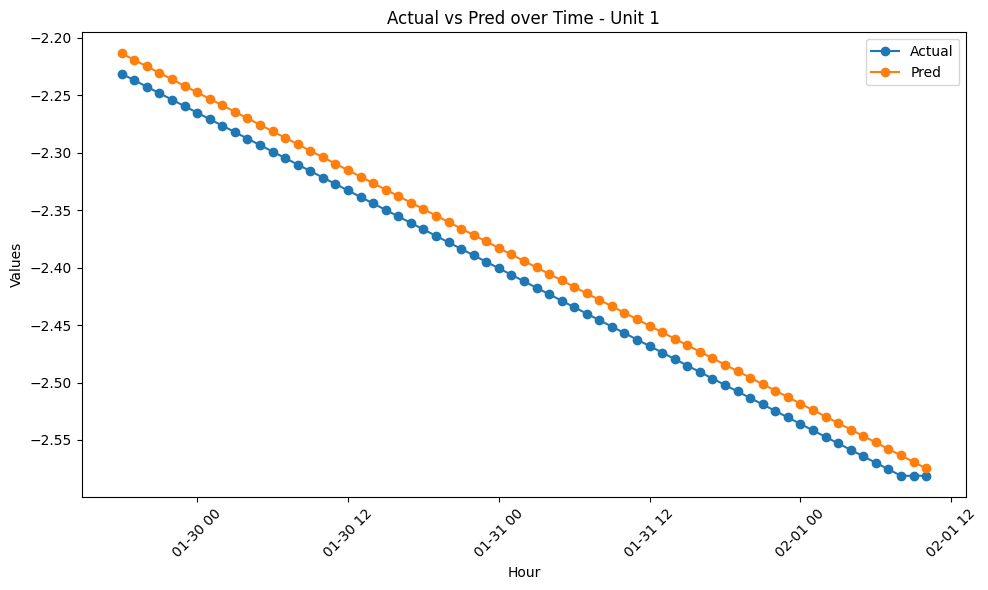

RMSE for Unit 1: 0.017486949794591058
{'train': [0, 918], 'valid': [406, 1033], 'test': [521, 1147]}
1148
Dataset for unit 2 is good


ValueError: Input dataset must not be null or zero length.

In [209]:
# Forecast each unit's RUL
# Assuming the necessary variables (e.g., train_df, context_length, units, tsp, timestamp_column, target_columns) are defined

units = np.arange(1,11)
split_configs = generate_split_configs(train_df, context_length, unit_numbers=units)

for unit in units:
    df_subset = train_df[train_df['unit_number'] == unit]
    df_subset = df_subset.reset_index(drop=True)
    split_config = split_configs[unit - 1]  # Access by index

    # Run data checks for debug
    print(split_config)
    print(len(df_subset))
    if test_df_subset is None or len(df_subset) == 0:
        print(f"No data available for unit {unit}")
    else:
        print(f"Dataset for unit {unit} is good")


    # Reset Preprocessor
    tsp = TimeSeriesPreprocessor(
      **column_specifiers,
      context_length=context_length,
      prediction_length=forecast_length,
      scaling=True,
      encode_categorical=True,
      scaler_type="standard",
    )
    
    # Generate datasets based on the split configuration
    train_dataset, valid_dataset, test_dataset = get_datasets(tsp, dataset=df_subset, split_config=split_config)

    
    # Assign the zeroshot model
    zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision="main", prediction_filter_length=24)

    # Initialize trainer with the model
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
    )

    # Evaluate the model on the test dataset
    print(zeroshot_trainer.evaluate(test_dataset))

    # Create a forecasting pipeline
    zs_forecast_pipeline = TimeSeriesForecastingPipeline(
        model=zeroshot_model,
        device="cpu",
        timestamp_column=timestamp_column,
        id_columns=[],  # Adjust id_columns if needed
        target_columns=target_columns,
        freq="1h"
    )

    # Retrieve test data start and end indices
    test_start_index, test_end_index = split_config['test']

    # Generate forecast
    processed_data = tsp.preprocess(train_df[test_start_index:test_end_index])
    zs_forecast = zs_forecast_pipeline(processed_data)

    # Compare forecast with actual data and prepare for plotting
    df = compare_forecast(zs_forecast, "timestamp", "RUL_prediction", "RUL", 12)
    df.dropna(inplace=True)

    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(df['timestamp'], df['actual'], label='Actual', linestyle='-', marker='o')
    plt.plot(df['timestamp'], df['pred'], label='Pred', linestyle='-', marker='o')

    # Add labels and legend
    plt.xlabel('Hour')
    plt.ylabel('Values')
    plt.title('Actual vs Pred over Time - Unit ' + str(unit))
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Calculate RMSE for the unit
    rmse = np.sqrt(mean_squared_error(df['actual'], df['pred']))
    print(f"RMSE for Unit {unit}: {rmse}")
    print("======================================================")
    

In [ ]:
# prompt: get the object type of test_df_subset

print(type(test_df_subset))

<class 'pandas.core.frame.DataFrame'>


# Fine Tuning
(work in progress)

In [ ]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm/TTM", revision="main", prediction_filter_length=24
)

In [ ]:
# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

In [ ]:
# Important parameters
learning_rate = 0.001
num_epochs = 20
batch_size = 32

finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

In [ ]:
# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.001,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dfset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    test_dfset=train_dfset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

In [ ]:
finetune_forecast_trainer.evaluate(test_dataset)

In [ ]:
test_data = tsp.preprocess(pollution_data[test_start_index:test_end_index])

In [ ]:
forecast_pipeline = TimeSeriesForecastingPipeline(
    model=finetune_forecast_model,
    device="cpu",
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    observable_columns=observable_columns,
    freq="1h"
)
context_length = finetune_forecast_model.config.context_length

In [ ]:
forecasts = forecast_pipeline(test_data)

In [ ]:
df = one_day_out_predictions
# Plot actual vs. pred
plt.figure(figsize=(10, 6))
plt.plot(df['hour'], df['actual'], label='Actual', linestyle='-', marker='o')
plt.plot(df['hour'], df['pred'], label='Pred', linestyle='-', marker='x')

# Add labels and legend
plt.xlabel('Hour')
plt.ylabel('Values')
plt.title('Actual vs Pred over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()